# Import Library

In [1]:
# load data
import os

# computing
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# feature extraction
import cv2
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans

# modelling
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# evalutaion
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# load/save model
import pickle

### Define common pickle method

In [2]:
def load_file_pickle(filename):
    file_pickle = pickle.load(open(filename, 'rb'))
    return file_pickle

def save_file_pickle(data, filename):
    pickle.dump(data, open(filename, 'wb'))

#### Constant variable

In [3]:
BOW_FILE_PICKLE = "bow_dictionary.pkl"
SCALER_WS_FILE_PICKLE = "scaler_with_sift.pkl"
SCALER_WOS_FILE_PICKLE = "scaler_without_sift.pkl"
SVM_WS_FILE_PICKLE = "svm_with_sift_model.pkl"
SVM_WOS_FILE_PICKLE = "svm_without_sift_model.pkl"

# Load Data

- input: -
- output: `raw_X, raw_y`

In [4]:
# ukurang gambar 224x224
def import_image(file) :
    image = cv2.imread(file)
    image = cv2.bitwise_not(image)
    return image

def label_image(character, length) :
    array = np.full(length, character)
    return array

def import_data(character, path) :
    file_path = os.listdir(path)
    images = np.array([import_image(path + '/' + file) for file in file_path])
    label = label_image(character, len(file_path))
    
    return images, label

In [5]:
hanacaraka = ('ba','ca','da','dha','ga','ha','ja','ka','la','ma','na','nga','nya','pa','ra','sa','ta','tha','wa','ya')

raw_X = np.empty((0, 224, 224, 3), np.uint8)
raw_y = np.empty((0))

folder_path = "../Dataset/campuran/" # for local used
# folder_path = "drive/MyDrive/Skripsi/Repos/Dataset/campuran/" # for drive used

for character in hanacaraka:
    dataset_path = folder_path + character

    temp_X, temp_y = import_data(character, dataset_path)

    print("Size of", character, ":", temp_X.shape[0])
    
    raw_X = np.append(raw_X, temp_X, axis=0)
    raw_y = np.append(raw_y, temp_y, axis=0)


Size of ba : 21
Size of ca : 21
Size of da : 21
Size of dha : 21
Size of ga : 21
Size of ha : 21
Size of ja : 21
Size of ka : 21
Size of la : 21
Size of ma : 21
Size of na : 21
Size of nga : 21
Size of nya : 21
Size of pa : 21
Size of ra : 21
Size of sa : 21
Size of ta : 21
Size of tha : 21
Size of wa : 21
Size of ya : 21


In [6]:
# Ukuran keseluruhan data
print("Number of data:", raw_X.shape[0])
print("Image dimension:", raw_X[0].shape)

Number of data: 420
Image dimension: (224, 224, 3)


### Visualize Raw Data

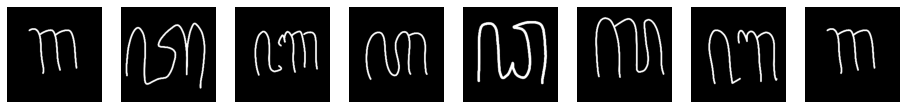

In [7]:
np.random.seed(42)

fig = plt.figure(figsize=(16, 4))
columns = 8
rows = 1
for i in range(1, columns*rows + 1):
    img = np.array(raw_X[np.random.randint(0, raw_X.shape[0]), :])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis('off')

plt.show()

# Augmantation & Preparation Data

- input: `raw_X, raw_y`
- output: `X, y`

List Augmented :
1. Rotate 30 CCW
2. Rotate 15 CCW + Zoom out
3. Rotate 15 CW + Zoom out
4. Rotate 30 CW
5. Shear Left
6. Shear Right
7. Normal

List Preprocessing :
1. Resizing (128x128)
2. Grayscaling
3. Equalization

### Augmented Method

In [8]:
# Augmented Method
def rotate(img, degree):
    (h, w) = img.shape[:2]
    (cX, cY) = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D((cX, cY), degree, 1.0)
    img_rotated = cv2.warpAffine(img, M, (w, h))
    return img_rotated

def zoom_out(img, zoom_scale):
    img_zoom = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)

    h, w = img.shape[0]/zoom_scale, img.shape[1]/zoom_scale
    h, w = int(h), int(w)
    x, y = (img.shape[0]-w)//2, (img.shape[1]-h)//2
    img_resize = cv2.resize(img, (h, w), interpolation = cv2.INTER_AREA)

    img_zoom[x:w+x, y:h+y] = img_resize
    return img_zoom

def shear(img, x, y):
    rows, cols = img.shape
    M = np.float32([[1, x, 0],
                    [y, 1, 0]])
    sheared_img = cv2.warpAffine(img, M, (cols, rows))
    return sheared_img

### Image Preprocessing Method

In [9]:
# Preprocessing Image
def equalizing(img):
    if (img.ndim == 3):
        b, g, r = cv2.split(img)
        red = cv2.equalizeHist(r)
        green = cv2.equalizeHist(g)
        blue = cv2.equalizeHist(b)
        img = cv2.merge((blue, green, red))
    else:
        img = cv2.equalizeHist(img)
    return img

def grayscaling(image):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    return image

def resizing(image, size):
    image = cv2.resize(image, (size, size), interpolation = cv2.INTER_AREA)
    return image

In [244]:
# Generate augmentation and preprocessing data
size = 192
def dataset_aug_generator_prep(ori_img, size):
    ori_img = resizing(ori_img, size)
    ori_img = grayscaling(ori_img)
    
    ori_img = zoom_out(ori_img, 1.15)
    img_r_30_ccw = rotate(ori_img, 30)
    img_r_30_cw = rotate(ori_img, -30)
    img_r_15_ccw_z = rotate(zoom_out(ori_img, 1.3), 15)
    img_r_15_cw_z = rotate(zoom_out(ori_img, 1.3), -15)
    img_s_left = shear(ori_img, -0.15, -0.15)
    img_s_right = shear(ori_img, 0.15, 0.15)
    
    result_aug = [ori_img, img_r_30_ccw, img_r_30_cw, img_r_15_ccw_z, img_r_15_cw_z, img_s_left, img_s_right]
    for idx, item_img in enumerate(result_aug):
        result_aug[idx] = equalizing(result_aug[idx])
    return result_aug

#### test result image after generate augmentation and preprocessing

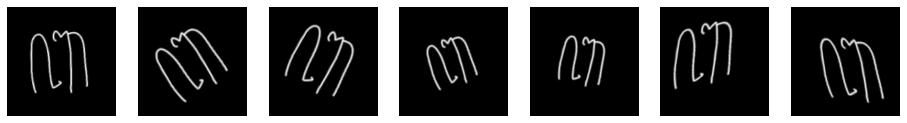

In [245]:
test_img_aug = dataset_aug_generator_prep(raw_X[0], size)

fig = plt.figure(figsize=(16, 4))
columns = 7
rows = 1
for i in range(1, columns*rows + 1):
    img = test_img_aug[i-1]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap='gray', vmin=0, vmax=255)
    plt.axis('off')

plt.show()

## Generate Aug & Prep Image on All Raw Data

In [246]:
X = np.empty((0, size, size), np.uint8)
y = np.empty((0))

for idx, img in enumerate(raw_X):
    img_aug = dataset_aug_generator_prep(img, size)
    
    for item_img in img_aug:
        X = np.append(X, [item_img], axis=0)
        y = np.append(y, [raw_y[idx]], axis=0)

In [247]:
print("Result X data dimension:", X.shape)
print("Result y data dimension:", y.shape)

Result X data dimension: (2940, 192, 192)
Result y data dimension: (2940,)


### Visualize Result Data

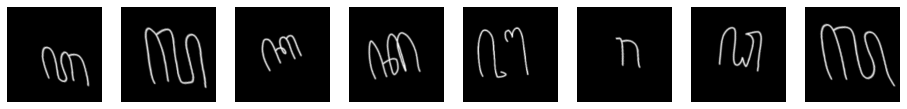

In [248]:
np.random.seed(42)

fig = plt.figure(figsize=(16, 4))
columns = 8
rows = 1
for i in range(1, columns*rows + 1):
    img = np.array(X[np.random.randint(0, X.shape[0]), :])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap='gray', vmin=0, vmax=255)
    plt.axis('off')

plt.show()

# Feature Extraction

- input: `X`
- output: `X_feature`

### Extract SIFT Descriptors 

In [249]:
def extract_sift_features(list_image):

    image_descriptors = []
    sift = cv2.SIFT_create()
    for image in list_image:
        _, descriptor = sift.detectAndCompute(image, None)
        image_descriptors.append(descriptor)

    return image_descriptors

def split_all_descriptors(image_descriptors):
    all_descriptors = []
    for descriptor in image_descriptors:
        if descriptor is not None:
            for des in descriptor:
                all_descriptors.append(des)
    
    return np.array(all_descriptors)

In [250]:
image_descriptors = extract_sift_features(X)

In [251]:
all_descriptors = split_all_descriptors(image_descriptors)
print("Number of keypoint descriptor:", all_descriptors.shape)

Number of keypoint descriptor: (193416, 128)


### Create BOW of Descriptor Using Cluster

In [252]:
def kmeans_bow(all_descriptors, num_cluster):
    # if not os.path.isfile(BOW_FILE_PICKLE):
    kmeans = KMeans(n_clusters = num_cluster, verbose=1)
    kmeans.fit(all_descriptors)

    bow_dict = kmeans.cluster_centers_
    
    save_file_pickle(bow_dict, BOW_FILE_PICKLE)
    # else:
    #     bow_dict = load_file_pickle(BOW_FILE_PICKLE)

    return bow_dict

In [253]:
num_cluster = 750
bow = kmeans_bow(all_descriptors, num_cluster)

Initialization complete
Iteration 0, inertia 2613602816.0
Iteration 1, inertia 1985647872.0
Iteration 2, inertia 1938412288.0
Iteration 3, inertia 1918920832.0
Iteration 4, inertia 1907804672.0
Iteration 5, inertia 1900316672.0
Iteration 6, inertia 1895145984.0
Iteration 7, inertia 1890739584.0
Iteration 8, inertia 1887285376.0
Iteration 9, inertia 1884617600.0
Iteration 10, inertia 1882483840.0
Iteration 11, inertia 1880780416.0
Iteration 12, inertia 1879440640.0
Iteration 13, inertia 1878231936.0
Iteration 14, inertia 1877255296.0
Iteration 15, inertia 1876358912.0
Iteration 16, inertia 1875459072.0
Iteration 17, inertia 1874683008.0
Iteration 18, inertia 1874050176.0
Iteration 19, inertia 1873612032.0
Iteration 20, inertia 1873237504.0
Iteration 21, inertia 1872864000.0
Iteration 22, inertia 1872537216.0
Iteration 23, inertia 1872244736.0
Iteration 24, inertia 1871996672.0
Iteration 25, inertia 1871827584.0
Iteration 26, inertia 1871704832.0
Iteration 27, inertia 1871595776.0
Iterat

### Create Features From BOW

In [254]:
def create_feature_bow(image_descriptors, bow, num_cluster):
    X_features = []

    for i in range(len(image_descriptors)):
        features = np.array([0] * num_cluster, dtype=float)

        if image_descriptors[i] is not None:
            distance = cdist(image_descriptors[i], bow)
            argmin = np.argmin(distance, axis = 1)

            for j in argmin:
                features[j] += 1.0
        X_features.append(features)

    return np.array(X_features)

In [255]:
X_feature = create_feature_bow(image_descriptors, bow, num_cluster)

print("Feature X data dimension:", X_feature.shape)

Feature X data dimension: (2940, 750)


# Classification With SIFT

- input: `X_feature, y`
- output: -

In [256]:
# normalization
scaler = StandardScaler().fit(X_feature)
X_scale = scaler.transform(X_feature)

#### Save scaler

In [257]:
# Just save normalization function for future used
save_file_pickle(scaler, SCALER_WS_FILE_PICKLE)

In [258]:
# splitting data
X_train, X_test, y_train, y_test = train_test_split(X_scale, y, test_size=0.15, random_state=42)

print("Size of training:", X_train.shape[0])
print("Size of testing:", X_test.shape[0])

Size of training: 2499
Size of testing: 441


### SVM

Using GridSearchCV for tuning parameter, with scenario:
- 'C': \[ 1, 3, 6, 10, 15 \]
- 'gamma': \[ 'auto', 0.001, 0.0015, 0.0025, 0.003 \]
    - 'auto' = 1 / nfeatures

#### Load model

In [259]:
# Just load model without re-training if you want
svm_ws = load_file_pickle(SVM_WS_FILE_PICKLE)

In [260]:
svm_ws_params = {
    'C': [1, 3, 6, 10, 15],
    'gamma': ['auto', 0.00090, 0.00095, 0.0018, 0.0023]
}
svm_ws = GridSearchCV(estimator=SVC(kernel='rbf', probability=True), param_grid=svm_ws_params, cv=5, verbose=3)

In [261]:
svm_ws.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ...................C=1, gamma=auto;, score=0.918 total time=   8.6s
[CV 2/5] END ...................C=1, gamma=auto;, score=0.890 total time=   8.7s
[CV 3/5] END ...................C=1, gamma=auto;, score=0.902 total time=   8.9s
[CV 4/5] END ...................C=1, gamma=auto;, score=0.888 total time=   9.0s
[CV 5/5] END ...................C=1, gamma=auto;, score=0.914 total time=   8.3s
[CV 1/5] END .................C=1, gamma=0.0009;, score=0.910 total time=   7.9s
[CV 2/5] END .................C=1, gamma=0.0009;, score=0.900 total time=   8.1s
[CV 3/5] END .................C=1, gamma=0.0009;, score=0.920 total time=   8.1s
[CV 4/5] END .................C=1, gamma=0.0009;, score=0.878 total time=   7.8s
[CV 5/5] END .................C=1, gamma=0.0009;, score=0.924 total time=   8.0s
[CV 1/5] END ................C=1, gamma=0.00095;, score=0.910 total time=   7.8s
[CV 2/5] END ................C=1, gamma=0.00095

GridSearchCV(cv=5, estimator=SVC(probability=True),
             param_grid={'C': [1, 3, 6, 10, 15],
                         'gamma': ['auto', 0.0009, 0.00095, 0.0018, 0.0023]},
             verbose=3)

In [262]:
print("Best Model:", svm_ws.best_estimator_)
print("Best CV Score:", svm_ws.best_score_)

Best Model: SVC(C=3, gamma=0.0009, probability=True)
Best CV Score: 0.9235719438877755


#### All result score CV from tuning parameter SVM

In [263]:
cv_results_df = pd.DataFrame(svm_ws.cv_results_)
cv_results_df = cv_results_df.sort_values(by=['rank_test_score'])
cv_results_df = (
    cv_results_df
    .set_index(cv_results_df["params"].apply(
        lambda x: "_".join(str(val) for val in x.values()))
    )
    .rename_axis('kernel')
)
cv_results_df[
    ['params', 'rank_test_score', 'mean_test_score', 'std_test_score']
]

,params,rank_test_score,mean_test_score,std_test_score
kernel,,,,
3_0.0009,"{'C': 3, 'gamma': 0.0009}",1,0.923572,0.006347
3_0.00095,"{'C': 3, 'gamma': 0.00095}",2,0.922773,0.007407
6_0.0009,"{'C': 6, 'gamma': 0.0009}",3,0.921574,0.010582
6_0.00095,"{'C': 6, 'gamma': 0.00095}",4,0.921174,0.010212
10_0.00095,"{'C': 10, 'gamma': 0.00095}",5,0.920373,0.009034
10_0.0009,"{'C': 10, 'gamma': 0.0009}",5,0.920373,0.009880
15_0.00095,"{'C': 15, 'gamma': 0.00095}",7,0.919972,0.008546
15_0.0009,"{'C': 15, 'gamma': 0.0009}",7,0.919972,0.009436
3_auto,"{'C': 3, 'gamma': 'auto'}",9,0.915971,0.008724


#### Save model

In [264]:
# Just save model for future used
save_file_pickle(svm_ws, SVM_WS_FILE_PICKLE)

### Predict Data Testing

Using SVC(C=6, gamma=0.0015)

In [265]:
y_pred = svm_ws.predict(X_test)

In [266]:
test = svm_ws.predict_proba(np.reshape(X_test[0], (1, -1)))
test

array([[1.71809042e-03, 2.02162872e-02, 2.96769836e-03, 1.52104564e-03,
        4.42884427e-04, 8.37697366e-04, 1.04490838e-03, 2.57821634e-03,
        9.84476081e-04, 9.42073484e-04, 5.54386385e-03, 7.35965025e-04,
        1.79995233e-03, 1.14045995e-04, 6.90123939e-05, 9.51421552e-01,
        9.53657783e-04, 3.44398169e-03, 3.25763027e-04, 2.33882850e-03]])

#### Heatmap result predict

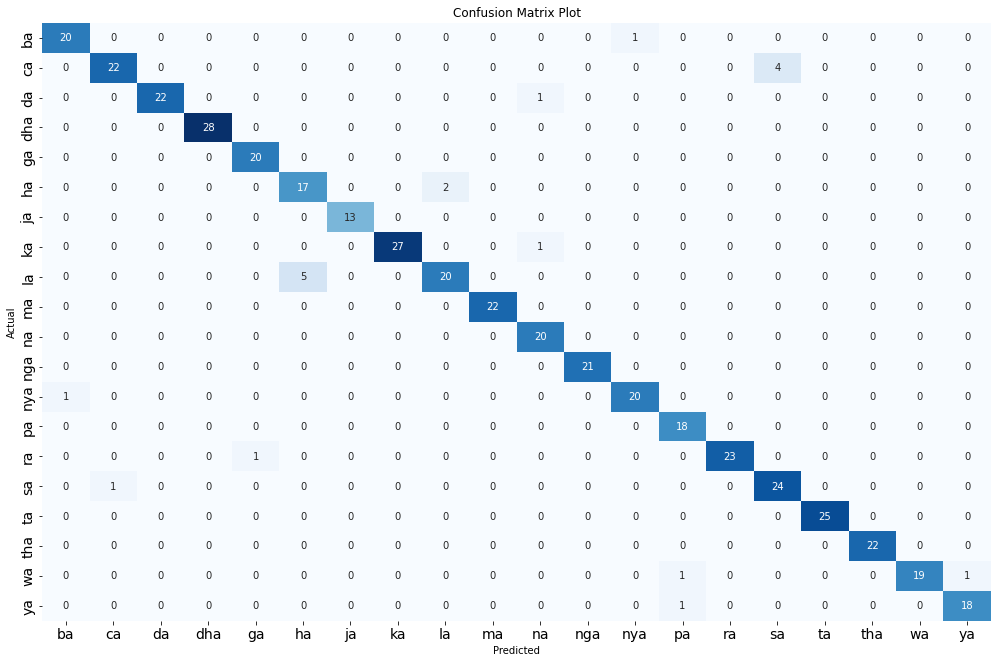

In [267]:
conf_ws = pd.DataFrame(confusion_matrix(y_test, y_pred), columns=hanacaraka, index=hanacaraka)

plt.figure(figsize=(17,11))

res = sns.heatmap(conf_ws, annot=True, fmt="g", cmap="Blues", cbar=False)
res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 14)
res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 14)

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix Plot")
plt.show()

In [268]:
class_rep_ws = classification_report(y_test, y_pred)

print("Classification report result:")
print(class_rep_ws)

Classification report result:
              precision    recall  f1-score   support

          ba       0.95      0.95      0.95        21
          ca       0.96      0.85      0.90        26
          da       1.00      0.96      0.98        23
         dha       1.00      1.00      1.00        28
          ga       0.95      1.00      0.98        20
          ha       0.77      0.89      0.83        19
          ja       1.00      1.00      1.00        13
          ka       1.00      0.96      0.98        28
          la       0.91      0.80      0.85        25
          ma       1.00      1.00      1.00        22
          na       0.91      1.00      0.95        20
         nga       1.00      1.00      1.00        21
         nya       0.95      0.95      0.95        21
          pa       0.90      1.00      0.95        18
          ra       1.00      0.96      0.98        24
          sa       0.86      0.96      0.91        25
          ta       1.00      1.00      1.00        

### Result Accuracy Score for SVM with SIFT

In [269]:
acc_ws = accuracy_score(y_test, y_pred)
print("Accuracy score:", acc_ws)

Accuracy score: 0.9546485260770975


# Note for Result SIFT With SVM

### Testing Scenario
- Img = \[ 64, 96, 128, 164, 192, 224 \]
  - Img prep = Greyscale, Equalization
- K = \[ 1000, 700, 500, 350, 240, 180 \]
- C = \[ 1, 3, 6, 10, 15\]
- G = \[ 'auto', 0.001, 0.0015, 0.0025, 0.003 \]

### Result:
- Img = (25,25), K = 180, SVM = 0.61
- Img = (28,28), K = 140, SVM = 0.59
- Img = (32,32), K = 140, SVM = 0.69
- Img = (64,64), K = 180, SVM = 0.89
- Img = (64,64), K = 240, SVM = .89:.90
- Img = (96,96), K = 240, SVM = .89:.89
- Img = (128,128), K = 140, SVM = .87:.89
- Img = (128,128), K = 180, SVM = .88:.93
- Img = (128,128), K = 240, SVM = .90:.95
- Img = (128,128), K = 350, SVM = .91:.94
- Img = (128,128), K = 500, SVM = .92:.95
- Img = (128,128), K = 700, SVM = .92:.94
- Img = (128,128), K = 1000, SVM = .92:.94
- Img = (164,164), K = 240, SVM = .90:.91
- Img = (192,192), K = 240, SVM = .90:.92
- Img = (224,224), K = 240, SVM = .88:.90


======================================

- Img = (128,128), K = 60, KNN = 0.69, SVM = 0.82
- Img = (128,128), K = 80, KNN = 0.71, SVM = 0.88
- Img = (128,128), K = 100, KNN = 0.76, SVM = 0.90
- Img = (128,128), K = 120, KNN = 0.74, SVM = 0.91
- Img = (128,128), K = 140, KNN = 0.78, SVM = 0.92
- Img = (128,128), K = 160, KNN = 0.76, SVM = 0.93
- Img = (128,128), K = 180, KNN = 0.75, SVM = 0.92
- Img = (128,128), K = 200, KNN = 0.75, SVM = 0.94 (G,T) / 0.92 (G,E) / 0.86 (G,E,T) / 0.86 (G,T,E)
- Img = (128,128), K = 240, KNN = 0.76, SVM = 0.96 (G,T) / 0.90:0.94 (G,E)
- Img = (128,128), K = 350, KNN = 0.75, SVM = 0.94
- Img = (128,128), K = 500, KNN = 0.76, SVM = 0.97
- Img = (128,128), K = 700, KNN = 0.71, SVM = 0.95
- Img = (128,128), K = 1000, KNN = 0.63, SVM = 0.95


### Conclusion
- Best image : 128x128
  1. 128: .90:.94
  2. 192: .90:.92
  3. 164: .90:.91
  4. 64: .89:.90
  5. 96: .89:.89
  6. 224: .88:.90
- Best K val : 500 
  1. 500 : .92:.95
  2. 240 : .90:.95
  3. 700 : .92:.94
  4. 1000 : .92:.94
  5. 350 : .91:.94
  6. 180 : .88:.93
- Best C val : 6
- Best G val : 0.0015

# Classification Without SIFT

- input: `X, y`
- output: -

### Image Preprocessing

Data should be resized for lower time consumtion training

In [35]:
# new_X = X
new_X = []

for i in range(X.shape[0]) :
    new_X.append(equalizing(resizing(X[i], 28)))
    
new_X = np.array(new_X, dtype=np.uint8)

### Visualize Result Data

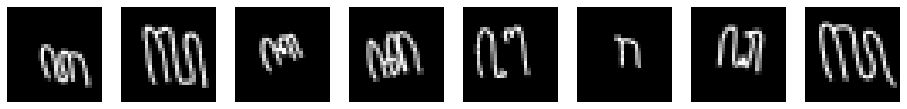

In [36]:
np.random.seed(42)

fig = plt.figure(figsize=(16, 4))
columns = 8
rows = 1
for i in range(1, columns*rows + 1):
    img = np.array(new_X[np.random.randint(0, new_X.shape[0]), :])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap='gray', vmin=0, vmax=255)
    plt.axis('off')

plt.show()

### Preprocessing

In [37]:
# reshape data
X_feature = np.reshape(new_X, (new_X.shape[0], new_X[0].shape[0]*new_X[0].shape[1]))
print("Feature X data dimension:", X_feature.shape)

Feature X data dimension: (2940, 784)


In [38]:
# normalization
scaler = StandardScaler().fit(X_feature)
X_scale = scaler.transform(X_feature)

#### Save scaler

In [39]:
# Just save normalization function for future used
save_file_pickle(SCALER_WOS_FILE_PICKLE)

In [40]:
# splitting data
X_train, X_test, y_train, y_test = train_test_split(X_scale, y, test_size=0.15, random_state=42)

print("Size of training:", X_train.shape[0])
print("Size of testing:", X_test.shape[0])

Size of training: 2499
Size of testing: 441


### SVM

Using GridSearchCV for tuning parameter, with scenario:
- 'C': \[ 1, 3, 6, 10, 15 \]
- 'gamma': \[ 'auto', 0.0008, 0.001, 0.0015, 0.0018 \]
    - 'auto' = 1 / nfeatures

#### Load model

In [41]:
# Just load model without re-training if you want
svm_wos = load_file_pickle(SVM_WOS_FILE_PICKLE)

In [42]:
svm_wos_params = {
    'C': [1, 3, 6, 10, 15],
    'gamma': ['auto', 0.0008, 0.001, 0.0015, 0.0018],
}
svm_wos = GridSearchCV(estimator=SVC(kernel='rbf', probability=True), param_grid=svm_wos_params, cv=5, verbose=3)

In [43]:
svm_wos.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ...................C=1, gamma=auto;, score=0.372 total time=   5.7s
[CV 2/5] END ...................C=1, gamma=auto;, score=0.386 total time=   4.5s
[CV 3/5] END ...................C=1, gamma=auto;, score=0.354 total time=   7.2s
[CV 4/5] END ...................C=1, gamma=auto;, score=0.368 total time=   7.6s
[CV 5/5] END ...................C=1, gamma=auto;, score=0.371 total time=   7.8s
[CV 1/5] END .................C=1, gamma=0.0008;, score=0.354 total time=   7.0s
[CV 2/5] END .................C=1, gamma=0.0008;, score=0.348 total time=   6.5s
[CV 3/5] END .................C=1, gamma=0.0008;, score=0.318 total time=   6.3s
[CV 4/5] END .................C=1, gamma=0.0008;, score=0.346 total time=   6.5s
[CV 5/5] END .................C=1, gamma=0.0008;, score=0.349 total time=   5.5s
[CV 1/5] END ..................C=1, gamma=0.001;, score=0.372 total time=   5.9s
[CV 2/5] END ..................C=1, gamma=0.001

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [1, 3, 6, 10, 15],
                         'gamma': ['auto', 0.0008, 0.001, 0.0015, 0.0018]},
             verbose=3)

In [44]:
print("Best Model:", svm_wos.best_estimator_)
print("Best CV Score:", svm_wos.best_score_)

Best Model: SVC(C=15, gamma=0.0015)
Best CV Score: 0.47459478957915835


#### All result score CV from tuning parameter SVM

In [45]:
cv_results_df = pd.DataFrame(svm_wos.cv_results_)
cv_results_df = cv_results_df.sort_values(by=['rank_test_score'])
cv_results_df = (
    cv_results_df
    .set_index(cv_results_df["params"].apply(
        lambda x: "_".join(str(val) for val in x.values()))
    )
    .rename_axis('kernel')
)
cv_results_df[
    ['params', 'rank_test_score', 'mean_test_score', 'std_test_score']
]

,params,rank_test_score,mean_test_score,std_test_score
kernel,,,,
15_0.0015,"{'C': 15, 'gamma': 0.0015}",1,0.474595,0.013932
15_auto,"{'C': 15, 'gamma': 'auto'}",2,0.472591,0.010457
6_0.0015,"{'C': 6, 'gamma': 0.0015}",3,0.472192,0.007324
10_0.001,"{'C': 10, 'gamma': 0.001}",4,0.471793,0.012712
6_auto,"{'C': 6, 'gamma': 'auto'}",5,0.470990,0.011132
6_0.001,"{'C': 6, 'gamma': 0.001}",6,0.470592,0.006964
10_0.0015,"{'C': 10, 'gamma': 0.0015}",7,0.469793,0.012805
10_auto,"{'C': 10, 'gamma': 'auto'}",8,0.469391,0.013164
6_0.0008,"{'C': 6, 'gamma': 0.0008}",9,0.466592,0.007350


#### Save model

In [46]:
# Just save model for future used
save_file_pickle(SVM_WOS_FILE_PICKLE)

### Predict Data Testing

Using SVC(C=10, gamma=0.0015)

In [47]:
y_pred = svm_wos.predict(X_test)

In [ ]:
test = svm_wos.predict_proba(np.reshape(X_test[0], (1, -1)))
test

#### Heatmap result predict

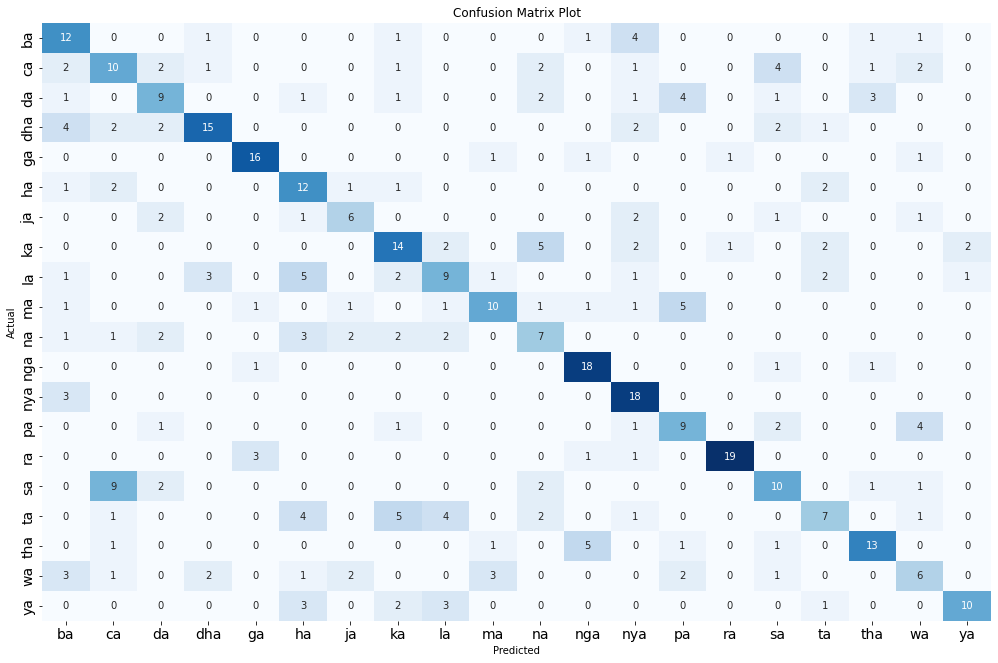

In [48]:
conf_wos = pd.DataFrame(confusion_matrix(y_test, y_pred), columns=hanacaraka, index=hanacaraka)

plt.figure(figsize=(17,11))

res = sns.heatmap(conf_wos, annot=True, fmt="g", cmap="Blues", cbar=False)
res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 14)
res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 14)

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix Plot")
plt.show()

In [49]:
class_rep_wos = classification_report(y_test, y_pred)

print("Classification report result:")
print(class_rep_wos)

Classification report result:
              precision    recall  f1-score   support

          ba       0.41      0.57      0.48        21
          ca       0.37      0.38      0.38        26
          da       0.45      0.39      0.42        23
         dha       0.68      0.54      0.60        28
          ga       0.76      0.80      0.78        20
          ha       0.40      0.63      0.49        19
          ja       0.50      0.46      0.48        13
          ka       0.47      0.50      0.48        28
          la       0.43      0.36      0.39        25
          ma       0.62      0.45      0.53        22
          na       0.33      0.35      0.34        20
         nga       0.67      0.86      0.75        21
         nya       0.51      0.86      0.64        21
          pa       0.43      0.50      0.46        18
          ra       0.90      0.79      0.84        24
          sa       0.43      0.40      0.42        25
          ta       0.47      0.28      0.35        

### Result Accuracy Score for SVM without SIFT

In [50]:
acc_wos = accuracy_score(y_test, y_pred)
print("Accuracy score:", acc_wos)

Accuracy score: 0.5215419501133787


# Note for Result SVM Without WIFT

### Result:

- Img = (25,25), SVM = 0.57
- Img = (28,28), SVM = 0.51
- Img = (32,32), SVM = 0.54
- Img = (64,64), SVM = 0.45

# SVM With SIFT vs SVM Without SIFT Comparison

In [51]:
compare_df = pd.DataFrame({"Model_SVM": ["Without SIFT", "With SIFT"],
                          "Accuracy": [acc_wos, acc_ws]})

compare_df

,Model_SVM,Accuracy
0,Without SIFT,0.521542
1,With SIFT,0.954649


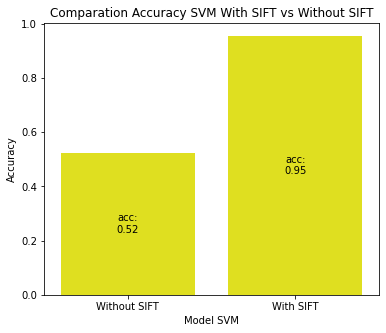

In [52]:
fig, ax = plt.subplots(figsize=(6, 5))

sns.barplot(x = 'Model_SVM',
            y = 'Accuracy',
            data = compare_df,
            ax=ax,
            color='yellow')

ax.bar_label(ax.containers[-1], fmt='acc:\n%.2f', label_type='center')
ax.set(ylabel='Accuracy', xlabel='Model SVM', title="Comparation Accuracy SVM With SIFT vs Without SIFT")

plt.show()

# Predict From Input File

In [53]:
from ipywidgets import Button
from tkinter import Tk, filedialog
from IPython.display import clear_output, display

# Load file ==================================================================================
def import_image(file) :
    image = cv2.imread(file)
    image = cv2.bitwise_not(image)
    return image
# ============================================================================================
# Preprocessing Image ========================================================================
def equalizing(img):
    img = cv2.equalizeHist(img)
    return img

def grayscaling(image):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    return image

def resizing(image, size):
    image = cv2.resize(image, (size, size), interpolation = cv2.INTER_AREA)
    return image

def prep_image(image):
    img = resizing(image, 128)
    img = grayscaling(img)
    img = equalizing(img)
    return img
# ============================================================================================
# Feature Extraction =========================================================================
def extract_sift_descriptor(image):
    sift = cv2.SIFT_create()
    _, descriptor = sift.detectAndCompute(image, None)
    return descriptor

def create_feature_bow(image_descriptor, bow, num_cluster):
    features = np.array([0] * num_cluster, dtype=float)

    if image_descriptor is not None:
        distance = cdist(image_descriptor, bow)
        argmin = np.argmin(distance, axis = 1)
        
        for j in argmin:
            features[j] += 1.0

    return np.array(features)

def extract_feature(image):
    img_descriptor = extract_sift_descriptor(image)
    
    num_cluster = 500
    bow = load_file_pickle(BOW_FILE_PICKLE)
    
    img_feature = create_feature_bow(img_descriptor, bow, num_cluster)
    return img_feature
# ============================================================================================
# Prediction Process =========================================================================
def predict_image(feature):
    scaler = load_file_pickle(SCALER_WS_FILE_PICKLE)
    feature_scale = scaler.transform([feature])
    
    svm_model = load_file_pickle(SVM_WS_FILE_PICKLE)
    result_predict = svm_model.predict(feature_scale)
    return result_predict
# ============================================================================================
# Open widget laod file ======================================================================
def select_files(b):
    clear_output()
    root = Tk()
    root.withdraw() 
    root.call('wm', 'attributes', '.', '-topmost', True)
    
    b.files = filedialog.askopenfilename(multiple=True) 
    print(b.files[0])
    processing_files(b.files[0])
# ============================================================================================
# Open widget laod file ======================================================================
def processing_files(file):
    img = import_image(file)
    plt.imshow(img, cmap='gray', vmin=0, vmax=255)
    img = prep_image(img)
    
    img_feature = extract_feature(img)
    result_predict = predict_image(img_feature)
    print("Result Class Prediction :", result_predict)
# ============================================================================================

fileselect = Button(description="File select")
fileselect.on_click(select_files)

display(fileselect)

Button(description='File select', style=ButtonStyle())